In [1]:

import matplotlib.pyplot as plt
import math as mat
import numpy as np
from numpy import polynomial
from numpy.random import *
from scipy.misc import *
from scipy.stats import kstest
from scipy.special import factorial
from scipy import optimize
from scipy import stats
     

# I) Générateurs pseudo-aléatoires

Un générateur de nombres pseudo-aléatoires, est un algorithme qui génère une séquence de nombres présentant certaines propriétés du hasard. Par exemple, les nombres sont supposés être suffisamment indépendants les uns des autres, et il est potentiellement difficile de repérer des groupes de nombres qui suivent une certaine règle (comportements de groupe).

Un algorithme déterministe génère des suites de nombres qui ne peuvent pas satisfaire complètement les critères mathématiques qualifiant les suites aléatoires. On les appelle suites pseudo-aléatoires, car leurs propriétés s'approchent seulement des propriétés idéales des suites aléatoires parfaites. Comme le faisait remarquer ironiquement John von Neumann : 

*« Quiconque considère des méthodes arithmétiques pour produire des nombres aléatoires »* disait-il *« est, bien sûr, en train de commettre un péché »*.

Un générateur pseudo-aléatoire est un algorithme qui à partir d'un certain nombre (la graine) et d'un entier , génère une suite de nombres de longueur 
vérifiant certaines propriétés statistiques rendant sa structure difficilement identifiable. La suite produite est déterministe puisqu'elle est générée par un algorithme : à longueur et graine fixées, l'algorithme génèrera toujours la même suite de nombres. On parle donc de générateurs pseudo-aléatoires.

La qualité d'une suite pseudo-aléatoire dépend de ses propriétés statistiques, on évalue donc cette suite avec des théorèmes et des outils statistiques comme par exemple la **loi de grands nombres** ou les **tests d'adéquation**.

Dans cette première partie, nous allons générer de nombres pseudo-aléatoires entre 0 et 1. Les générateurs uniformes nous permettent de construire ensuite tous les générateurs de loi de probabilités usuelles. Nous allons illustrer à l'aide de différents générateurs pseudo-aléatoires les biais et limites empêchant la génération d'une suite parfaitement aléatoire.

Les algorithmes de géneration que nous avons implémenté ont une même structure:

- ils nécessitent un nombre initial nommé la graine.
- les nombres qui suivent sont définis par une relation de récurrence. 

## I.0 ) Évaluer un algorithme 

Pour évaluer un algorithme, nous utilisons certaines propriètés statistiques de la loi uniforme sur $[0,1]$ :

* Loi des grands nombres : la moyenne empirique doit tendre vers $ \frac{1}{2} $
 
* Test de Kolmogorov Smirnov : la fonction de répartiton empirique doit être "proche" de la fonction de répartition théorique. 

* Algorithme de FLoyd (algorithme du lièvre et de la tortue) : la liste des nombres générés ne doit pas comporter de périodes, c'est à dire une certaine succesion de nombres qui se répèteraient. 

**Loi forte des grands nombres**

In [20]:
# Loi des grands nombres 

def LGN(X):
    return np.abs(np.mean(X) - 0.5)

**Test de Kolmogorov Smirnov**

Données : $n$ observations d'une variable aléatoire $X$, $q$ observations d'une variable aléatoire $Y$.

Hypothèse testée : "Les fonctions de répartition de $X$ et de $Y$ sont égales" avec risque d'erreur $a$.

Calcul de la fonction de répartition : 

- On ordonne les valeurs observées $x_1\leq x_2\leq\cdots\leq x_n$.
- On considère la fonction de répartition empirique $F$ définie par 
$ f(x) = \begin{cases}
        0, & \text{si } x < x_1 \\
        \frac{1}{n}, & \text{si } x_1 \le x \le x_2 \\
        ... \\
        \frac{i}{n}, & \text{si } x_i \le x \le x_{i+1} \\
        1, & \text{si } x > x_n
    \end{cases} $

On calcule $ K=\sup |F_X(x)-F_Y(x)| $ et on compare avec la valeur critique de la loi du $\delta$ de Kolmogorov-Smirnov : si b est tel que $P (\delta > b) = a$ et si $ K < \sqrt{ \frac{p + q}{ pq }} b$ alors on accepte l'hypothèse, sinon on la rejette.

Condition de validité : $p$ et $q$ grands car on approxime la loi de $ | F_X - F_Y | $ par la loi limite. 

Ce test repose sur deux théorèmes, le **théorème de Glivenko Cantelli** et le **théorème de Kolmorov**. 

Soit $(X_{n})_{n}$ une suite de variables aléatoires *iid* de f.d.r. $F$ ($F$ est inconnue et on cherche à déterminer si $F=F_{ref}$. On note $F_{n}$ la fonction de répartition empirique, le théorème de Glivenko Cantelli nous assure que $D_{n} :=||F_{n} -F||_{∞}$ converge presque sûrement vers $0$. $F_{n}$ est donc un estimateur satisfaisant de $F$. De plus, le théorème de Kolmogorov assure que si $F$ est continue alors la loi de $D_{n}$ ne depend pas de $F$. Ce résultat  est très pratique puisqu'il rend la variable $D_{n}$ universelle, un test basé sur $D_{n}$ sera valable pour n'importe quelle variable aléatoire dont la fonction de  répartition est continue. La loi $D_{n}$ est tabulée, on note $d_{n,\alpha}$ son quantile d'ordre $\alpha$. Le test de Kolmogorov Smirnov de niveau $\alpha$, sous l'hypothèse nulle $F=F_{ref}$, est :


$\phi:=1_{D_{n}>d_{n,1-\alpha}}$ avec cette fois ci $D_{n} :=||F_{n} -F_{ref}||_{∞}$, $F$ étant inconnue.  


Le calcul pratique de $D_{n}$ est facilité par la formule suivante:
$D_n = \max_{1 \leq i \leq n} \max \left\{ \frac{i}{n} - F(X_{(i)}), \, F(X_{(i)}) - \frac{i-1}{n}\right\}.$ où les $(X_{(i)})_{i}$ sont supposés ordonnés.

In [4]:
# On commence par définir Dn 
def Dn(X, Fref):
    X_sorted = np.sort(X)
    n = len(X)
    max_left = [max( 
                    i / float(n) -  Fref(X_sorted[i-1]) , 
                    (i-1) / float(n) - Fref(X_sorted[i-1])
                    ) 
                for i in list(range(1 , n+1))]
    return max(max_left)

#test de Kolmogorov
#les quantiles sont tabulés, on importe la table des quantiles avec scipy.stats:
from scipy.stats import ksone

def dn_value(alpha,n):
    return ksone.ppf(1-alpha, n)  #quantile d'ordre 1-alpha pour un certain n

def test_kolmogorov(X,Fref,alpha):
    if Dn(X,Fref) > dn_value(alpha,len(X)): return "L'échantillon ne suit pas la loi de réfèrence"
    return "L'échantillon suit la loi de réfèrence"

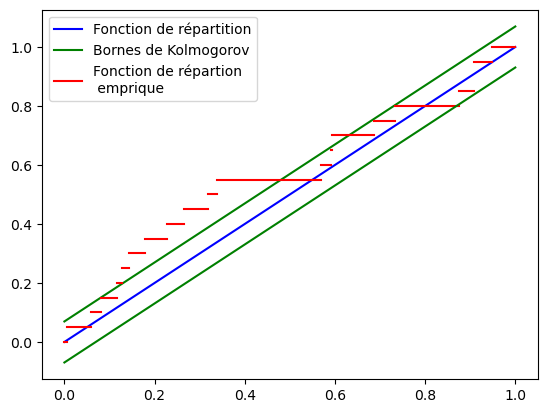

test de kolmogorov smirnov: L'échantillon ne suit pas la loi de réfèrence


In [8]:
n = 20
d = dn_value(0.05,n)

# Fonction de répartition
xx = np.linspace(0,1,101)
plt.plot(xx,xx,'b')

#borne sup de kolmogorov
plt.plot(xx,xx+d,'g')


#Fonction de répartition empirique
U = rand(n)
X = np.sort(U)
plt.plot([0,X[0]],[0,0],'r-')
for i in range(1,n):
    plt.plot([X[i-1],X[i]],[i/float(n),i/float(n)],'r-') 
plt.plot([X[-1],1],[1,1],'r-')

#borne inf de kolmogorov
plt.plot(xx,xx-d,'g')
plt.legend(["Fonction de répartition", "Bornes de Kolmogorov","Fonction de répartion \n emprique"])
plt.show()

#si la fdr empirique  est bien entre les deux droites vertes on peut affirmer que F=Fref.
print("test de kolmogorov smirnov:",test_kolmogorov(U, lambda x:x,0.05))

**Algorithme de Floyd**  

L'algorithme de Floyd (ou du lièvre et de la tortue) permet de détecter des cycles dans une liste de nombres $(x_{k})_{k}$. Cet algorithme repose sur le fait que si la liste admet un cycle, il existe un indice $j$ tel que $x_{j} = x_{2j}$. On parcourt donc la liste à deux vitesses, la tortue à une vitesse $1$ et le lièvre à une vitesse $2$. Ainsi le lièvre va commencer par parcourir $x_{2},x_{4}, x_{6}, x_{8}$ alors que la tortue parcourira $x_{1}, x_{2}, x_{3}, x_{4}$. Comparer le lièvre et la tortue nous permet de comparer les couples $(x_{k},x_{2k})$ et donc de trouver le cycle.

In [10]:
def Floyd(f, x0):
    m = 0 
    tortue = f(x0)
    lievre = f(tortue)
    while tortue!=lievre and m < 10**5:
        m += 1
        tortue = f(tortue)  #vitesse1
        lievre = f(f(lievre))  #vitesse2
    
    if m == 10**5: 
        return "pas de cycle trouvé"
    
    return "présence d'un cycle"   

## I-1 ) Générateur de nombres pseudos-aléatoires : algorithme de Von Neuman

En 1946, John von Neumann propose un générateur pseudo-aléatoire connu sous le nom de la méthode middle-square (carré médian). Très simple, elle consiste à prendre un nombre, à l'élever au carré et à prendre les chiffres au milieu comme sortie.

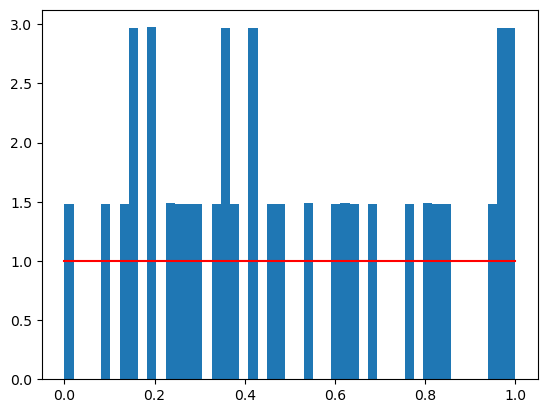

In [22]:
def f_iteration(x):
        carre = int(x) ** 2
        taille = len(str(carre))
        if taille % 2 != 0:
            carre = int(str(carre) + "0")
            taille +=1
            res = str(carre)[2:6]
        else:
            res = str(carre)[2:6]
        return res

def VonNeuman(x0, n):
    """
    x_o : nombre initial
    n : longueur de la suite de nombre pseudo aléatoire souhaitée
    return liste de nombre pseudos aléatoires
    """
    liste_pa = [x0]
    for i in range(n):
        liste_pa.append(f_iteration(liste_pa[-1]))
    liste_pa =  list(map(int, liste_pa))
    return liste_pa

# test
X = VonNeuman(1783,10**4)
Y = [i / max(X) for i in X]  #pour avoir des nombres entre 0 et 1
plt.hist(Y, bins=np.linspace(0,1,50), density=True)
plt.plot([0,1],[1,1],'r')  #densité théorique
plt.show()

Testons cet algorithme :

In [28]:
# Test LGN 
print(LGN(Y))  # 0.001509585216009024 < 0.05

# Présence de cycles ? 
print(Floyd(f_iteration, 1784))

# Test de Kolmogorov 
test_kolmogorov(Y, lambda x:x, 0.05) 

0.001509585216009024
présence d'un cycle


"L'échantillon ne suit pas la loi de réfèrence"